# 1. Exploración y Limpieza de Datos
En este notebook aplicaremos los pasos del Análisis Exploratorio de Datos (EDA) inicial, calcularemos la Disponibilidad General de la planta y generaremos gráficos mejorados.

Cargando y limpiando datos...

--- Exploración Inicial ---


,interval_start,equipment_ID,alarm,type,start,end,elapsed,pi,po,speed
0,2020-01-01 11:21:28.907000+00:00,s_1,A_000,scheduled_downtime,1.577878e+09,1.577878e+09,63050,59916598,59517799,0
1,2020-01-01 11:22:31.957000+00:00,s_1,A_000,idle,1.577878e+09,1.577878e+09,30840,59916598,59517799,0
2,2020-01-01 11:23:02.797000+00:00,s_1,A_000,scheduled_downtime,1.577878e+09,1.577879e+09,1410671,59916598,59517799,0
3,2020-01-01 11:46:33.468000+00:00,s_1,A_000,idle,1.577879e+09,1.577881e+09,1524520,59916598,59517799,0
4,2020-01-01 12:11:57.988000+00:00,s_1,A_000,scheduled_downtime,1.577881e+09,1.577884e+09,2831270,59916598,59517799,0



Información del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429394 entries, 0 to 429393
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   interval_start  429394 non-null  datetime64[ns, UTC]
 1   equipment_ID    429394 non-null  object             
 2   alarm           429394 non-null  object             
 3   type            429394 non-null  object             
 4   start           429394 non-null  float64            
 5   end             429394 non-null  float64            
 6   elapsed         429394 non-null  int64              
 7   pi              429394 non-null  int64              
 8   po              429394 non-null  int64              
 9   speed           429394 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(2), int64(4), object(3)
memory usage: 32.8+ MB
None

Valores Nulos por Columna:
interval_start    0
equipment_ID      0
alarm  

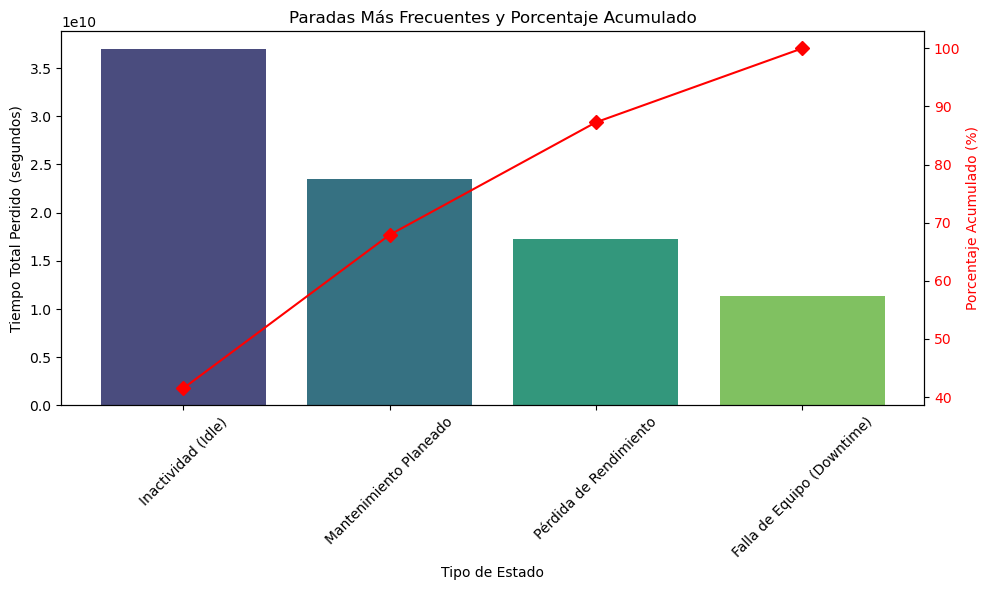


Calculando rendimiento por equipo y disponibilidad...


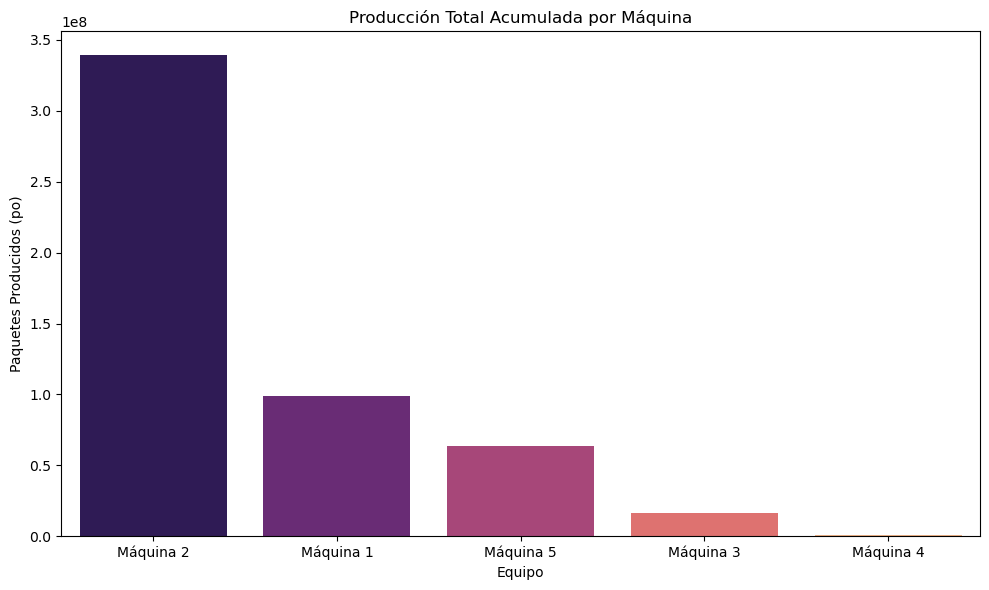


Generando análisis temporal...


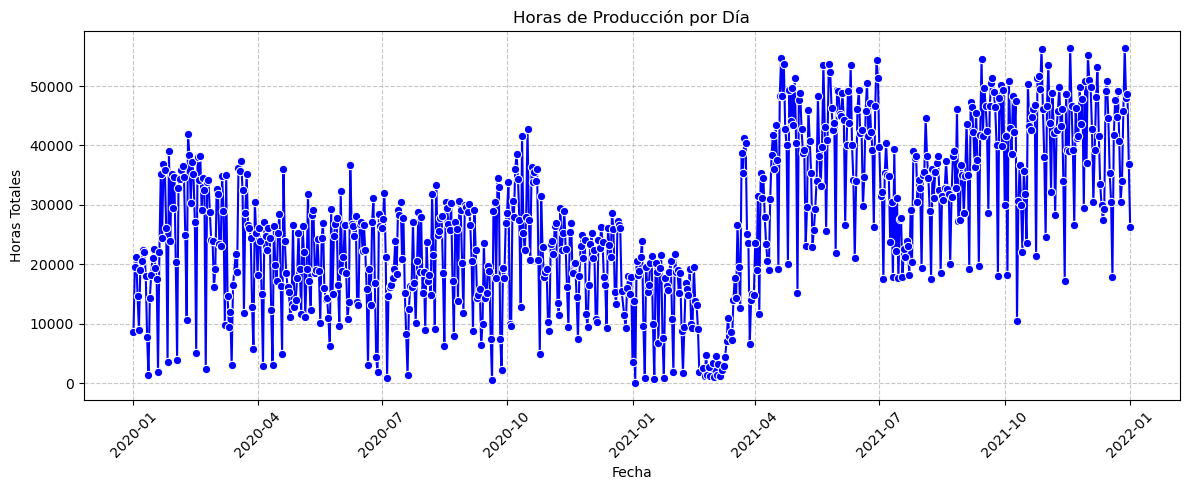


--- RESULTADOS PARA EL REPORTE ---
Disponibilidad General de la Planta: 43.94%

Top 3 causas de inactividad (Tiempo perdido en % del total):
 - Inactividad (Idle): 41.49%
 - Mantenimiento Planeado: 26.41%
 - Pérdida de Rendimiento: 19.37%

Máquina con mayor producción: Máquina 2


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Cargar datos y transformar fechas
print("Cargando y limpiando datos...")
df = pd.read_csv('../datos/raw_data.csv')
df['interval_start'] = pd.to_datetime(df['interval_start'], format='mixed')

# 1.1 Exploración Inicial de Datos (EDA)
print("\n--- Exploración Inicial ---")
display(df.head())
print("\nInformación del Dataset:")
print(df.info())
print("\nValores Nulos por Columna:")
print(df.isnull().sum())

# 2. Análisis de Tiempo de Inactividad (Downtime) y Pareto
print("\nCalculando tiempos de inactividad...")

# Diccionario para traducir categorías
traduccion_estados = {
    'idle': 'Inactividad (Idle)',
    'scheduled_downtime': 'Mantenimiento Planeado',
    'performance_loss': 'Pérdida de Rendimiento',
    'downtime': 'Falla de Equipo (Downtime)',
    'production': 'Producción'
}
df['tipo_estado'] = df['type'].map(traduccion_estados).fillna(df['type'])

downtime_df = df[df['tipo_estado'] != 'Producción']
pareto_data = downtime_df.groupby('tipo_estado')['elapsed'].sum().sort_values(ascending=False)
pareto_porcentaje = (pareto_data / pareto_data.sum()) * 100
pareto_acumulado = pareto_porcentaje.cumsum()

# 3. Visualización 1: Gráfico de Paradas Más Frecuentes (Pareto Mejorado)
fig, ax1 = plt.subplots(figsize=(10, 6))
sns.barplot(x=pareto_data.index, y=pareto_data.values, palette='viridis', hue=pareto_data.index, legend=False, ax=ax1)
ax1.set_title('Paradas Más Frecuentes y Porcentaje Acumulado')
ax1.set_ylabel('Tiempo Total Perdido (segundos)', color='black')
ax1.set_xlabel('Tipo de Estado')
ax1.tick_params(axis='x', rotation=45)

ax2 = ax1.twinx()
ax2.plot(pareto_data.index, pareto_acumulado.values, color='red', marker='D', ms=7)
ax2.set_ylabel('Porcentaje Acumulado (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
import os
if not os.path.exists('../visualizaciones'):
    os.makedirs('../visualizaciones')
plt.savefig('../visualizaciones/pareto_downtime.png')
plt.show()

# 4. Análisis de Rendimiento y Disponibilidad General
print("\nCalculando rendimiento por equipo y disponibilidad...")
total_time = df['elapsed'].sum()
production_time = df[df['tipo_estado'] == 'Producción']['elapsed'].sum()
disponibilidad = (production_time / total_time) * 100

# Diccionario para renombrar equipos
nombres_equipos = {
    's_1': 'Máquina 1', 's_2': 'Máquina 2', 's_3': 'Máquina 3',
    's_4': 'Máquina 4', 's_5': 'Máquina 5'
}
df['equipo_nombre'] = df['equipment_ID'].map(nombres_equipos).fillna(df['equipment_ID'])
produccion_equipos = df.groupby('equipo_nombre')['po'].max().sort_values(ascending=False)

# 5. Visualización 2: Producción Total por Equipo
plt.figure(figsize=(10, 6))
sns.barplot(x=produccion_equipos.index, y=produccion_equipos.values, palette='magma', hue=produccion_equipos.index, legend=False)
plt.title('Producción Total Acumulada por Máquina')
plt.ylabel('Paquetes Producidos (po)')
plt.xlabel('Equipo')
plt.tight_layout()
plt.savefig('../visualizaciones/produccion_equipos.png')
plt.show()

# 6. Análisis Temporal: Tiempo de Producción a lo largo del tiempo
print("\nGenerando análisis temporal...")
df['fecha'] = df['interval_start'].dt.date
produccion_diaria = df[df['tipo_estado'] == 'Producción'].groupby('fecha')['elapsed'].sum() / 3600 # horas

plt.figure(figsize=(12, 5))
sns.lineplot(x=produccion_diaria.index, y=produccion_diaria.values, marker='o', color='b')
plt.title('Horas de Producción por Día')
plt.ylabel('Horas Totales')
plt.xlabel('Fecha')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('../visualizaciones/produccion_temporal.png')
plt.show()

# 7. Mostrar resultados en texto para el reporte
print("\n--- RESULTADOS PARA EL REPORTE ---")
print(f"Disponibilidad General de la Planta: {disponibilidad:.2f}%")
print("\nTop 3 causas de inactividad (Tiempo perdido en % del total):")
for causa, valor in pareto_porcentaje.head(3).items():
    print(f" - {causa}: {valor:.2f}%")
print(f"\nMáquina con mayor producción: {produccion_equipos.index[0]}")